In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)
import seaborn as sns
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from hmmlearn.hmm import GaussianHMM
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, ExpSineSquared, RationalQuadratic
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA as sklearnPCA
from mpl_toolkits.mplot3d import Axes3D
from __future__ import division
import warnings; warnings.simplefilter('ignore')
from sklearn.externals import joblib

This project aims to predict the energy consumption (electric load) of residential structures.  The data is obtained from Pecan Street research and is taken from 1000 homes in the Austin, TX area. The 12 features consist of weather related metrics (humidity, dry-bulb temperature, etc.) and time related variables (time of day, etc.). The training period was collected between 01/01/2015 to 12/31/2015, and the testing period between 01/01/216 to 12/31/2016. The data has already been normalized.

Two models will be compared - a Gaussian Process regression model and a Hidden Markov Model with a Gaussian Process regression trained for each hidden state.  

In [2]:
# load the training and testing data
train_X = np.load('C:/Users/spenc/Documents/COURSES/CS6961_StructuredPrediction/Project/X_t.npy')
train_Y = np.load('C:/Users/spenc/Documents/COURSES/CS6961_StructuredPrediction/Project/Y_t.npy')
test_X = np.load('C:/Users/spenc/Documents/COURSES/CS6961_StructuredPrediction/Project/X_e.npy')
test_Y = np.load('C:/Users/spenc/Documents/COURSES/CS6961_StructuredPrediction/Project/Y_e.npy')

#train_X = np.append(train_X, test_X[0:4000,:], axis=0)

We define some functions that will be used later for visualization and evaluation

In [189]:
# Returns the root mean squared error of the parameters
def rmse(y_pred, y):
    return mean_squared_error(y, y_pred)**0.5

# produces a 3D plot when passed a pca dimensionality reduction matrix
def plot_3d(pca, colors = None):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca[:,0],pca[:,1], pca[:,2], s=15, c=colors)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.legend()
    plt.show()
    
def plot_y(data, title, xlab, ylab, data_lab = None):
    col = ['blue', 'red']
    plt.figure(figsize=(12, 8))
    if data_lab == None:
        plt.plot(data[0], label = data_lab)
    else:
        for index in range(len(data)):
                plt.plot(data[index], label = data_lab[index], color = col[index])
    plt.suptitle(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.legend()
    plt.show()
    
def plot_CI(title, true, pred, sd, ci, hr_begin, hrs):
    choices = {90: 1.645, 95: 1.96, 99:2.58}
    z = choices.get(ci, 'default')
    upper = pred.flatten() + z*sd
    lower = pred.flatten() - z*sd
    plt.figure(figsize=(12, 8))
    plt.fill_between(np.arange(hrs-hr_begin), upper[hr_begin:hrs], lower[hr_begin:hrs], color='grey', label = str(ci) +'% Confidence Interval')
    plt.scatter(np.arange(hrs-hr_begin), true[hr_begin:hrs], c='blue', label = 'True')
    plt.plot(true[hr_begin:hrs], c='blue')
    plt.scatter(np.arange(hrs-hr_begin), pred[hr_begin:hrs], c='red', label='Predicted')
    plt.suptitle(title)
    plt.legend(fontsize = 'large')
    plt.show()
    in_ci = []
    for idx in xrange(len(true)):
        if  true[idx] > lower[idx] and true[idx] < upper[idx]:
            in_ci.append(1)
        else:
            in_ci.append(0)
    return sum(in_ci) / len(pred)

  

We make a few plots to visualize and understand the Y variable, what we are trying to predict. The response (train_Y) looks Gamma distributed. 

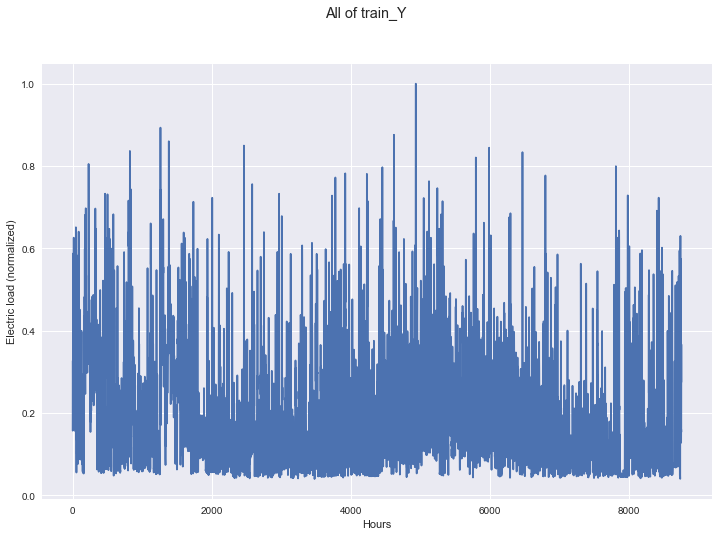

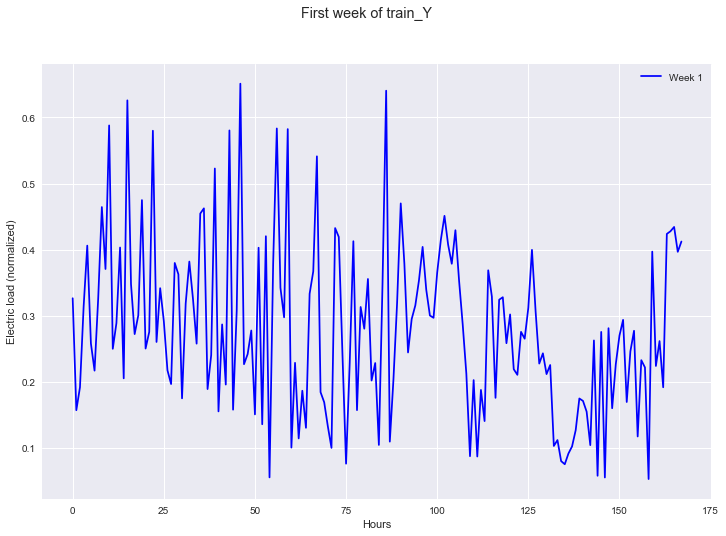

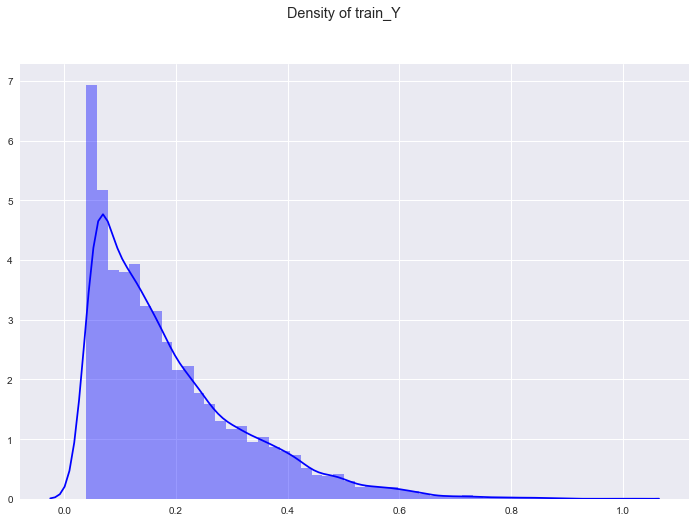

In [190]:
# Plot the entire response variable
plot_y([train_Y], 'All of train_Y', 'Hours', 'Electric load (normalized)')

# Plot the first week to get a closer look at the data
plot_y([train_Y[0:168]], 'First week of train_Y', 'Hours', 'Electric load (normalized)', data_lab=['Week 1'])

# Density plot of the response variable, i.e. the distribution
plt.figure(figsize=(12, 8))
sns.distplot(train_Y, norm_hist=True, color = 'blue')
sns.plt.suptitle('Density of train_Y')
sns.plt.show()

I used 20-fold cross validation on many kernel combinations to find the best covariance kernel (prior distribution) for the Gaussian Process model.  The time complexity of a Gaussian Process model is roughly $O(n^3)$ making cross validation time consuming.  The best kernel was the ConstantKernel() + RationalQuadratic() + WhiteKernel(). The sklearn implementation of Gaussian Process Regressor will tune the kernel hyperparameters for you during the fitting process so the only cross validation needed was for the kernel selection.  

In [216]:
kernel = ConstantKernel() + RationalQuadratic() + WhiteKernel()

In [ ]:
gp_model = gaussian_process.GaussianProcessRegressor(kernel=kernel, normalize_y = True, n_restarts_optimizer = 5).fit(
    train_X, train_Y)

In [192]:
# save the model 
#joblib.dump(model, 'GP_model.pkl') 

# to load model run
gp_model = joblib.load('GP_model.pkl') 

Look at the $R^2$ and RMSE of the trained model on train_Y.

In [8]:
# Get predictions and standard deviations of the model on train_X
train_pred, train_std = gp_model.predict(train_X, return_std=True)

R-squared:  0.880645760296
RMSE:  0.0467658486454


In [193]:
#print the r-squared ad rmse
print 'R-squared: ', gp_model.score(train_X, train_Y)
print 'RMSE: ', rmse(train_pred, train_Y)

R-squared:  0.880645760296
RMSE:  0.0467658486454


Lets plot the true train_Y and the predicted Y for the training data to get a visual of the model predictions with a 95% confidence interval. 

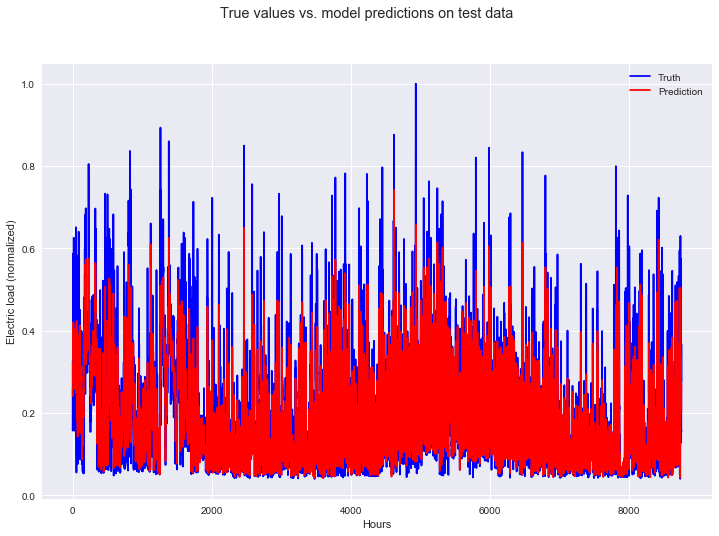

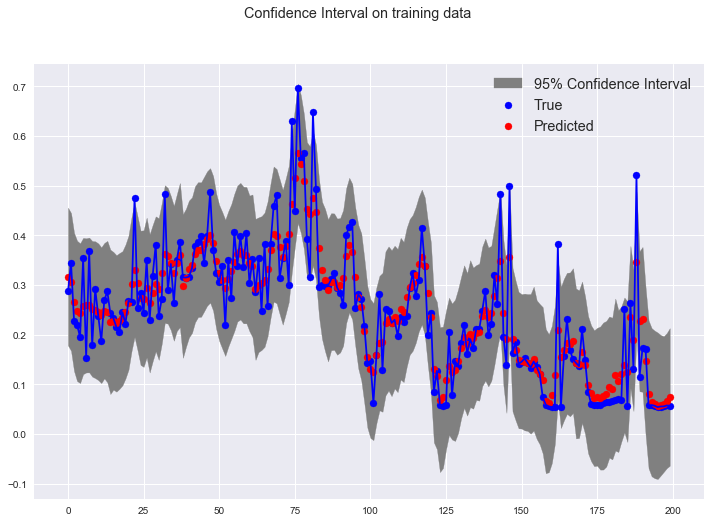

The percent of true values that fall within the confidence interval is  97.5342465753 %


In [196]:
plot_y([train_Y, train_pred],  'True values vs. model predictions on test data', 'Hours', 'Electric load (normalized)', ['Truth','Prediction'])

in_ci = plot_CI('Confidence Interval on training data', train_Y, train_pred, train_std, 95, 250, 450)

print 'The percent of true values that fall within the confidence interval is ', 100*in_ci,'%'

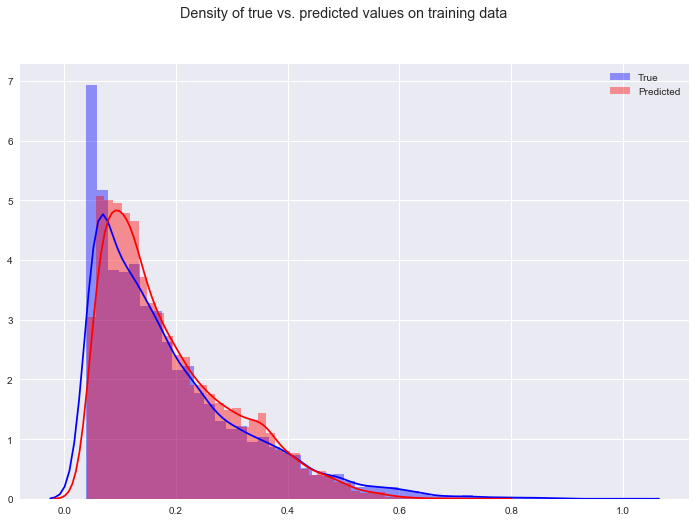

In [197]:
# Density plot of the test response variable and the predicted values
plt.figure(figsize=(12, 8))
sns.distplot(train_Y, norm_hist=True, color = 'blue', label = 'True')
sns.distplot(train_pred, norm_hist=True, color = 'red', label = 'Predicted')
sns.plt.suptitle('Density of true vs. predicted values on training data')
sns.plt.legend()
sns.plt.show()

$97.5\%$ of the true Y values from the training set are within a $95\%$ confidence interval predicted by the trained model.  Let's make predictions on the test data and evaluate how the model does on unseen data.

In [37]:
# get the predictions and standard deviation for the test data
test_pred, test_std = gp_model.predict(test_X, return_std=True)

In [319]:
print test_pred

[[ 0.22113511]
 [ 0.23241516]
 [ 0.23536435]
 ..., 
 [ 0.21876123]
 [ 0.21589027]
 [ 0.21416796]]


In [198]:
#print the r-squared ad rmse
print 'R-squared: ', gp_model.score(test_X, test_Y)
print 'RMSE: ', rmse(test_pred, test_Y)

R-squared:  0.416270225651
RMSE:  0.0932769885879


The $R^2$ value took quite a hit on the test data giving .41627, significantly less than the training $R^2$ of .88.  The RMSE on the unseen data was also worse but this is to be expected.  Let's look at some plots of the predicted values vs. the true values.

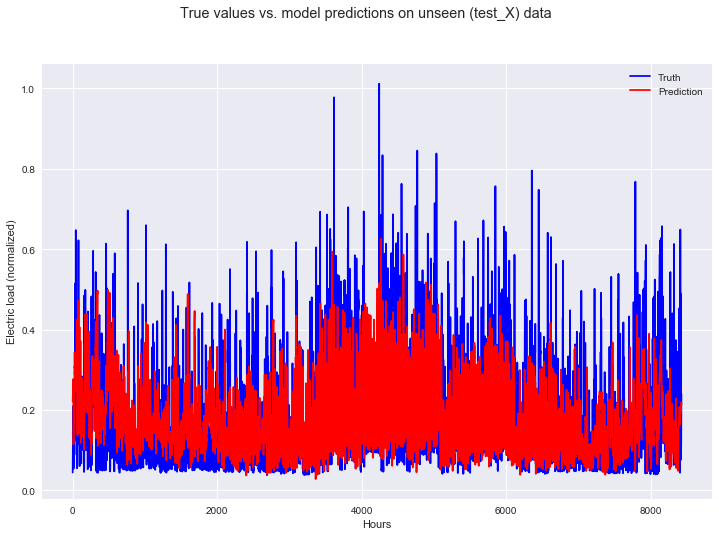

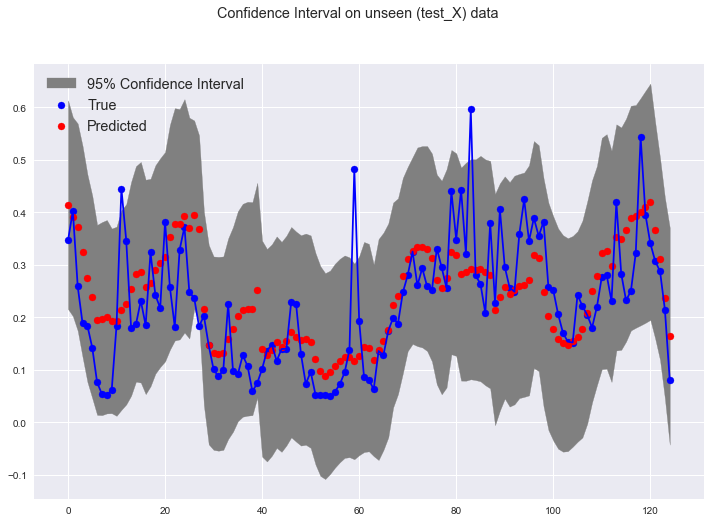

The percent of true values that fall within the confidence interval is  94.5512820513 %


In [200]:
plot_y([test_Y, test_pred],  'True values vs. model predictions on unseen (test_X) data', 'Hours', 'Electric load (normalized)', ['Truth','Prediction'])

in_ci = plot_CI('Confidence Interval on unseen (test_X) data', test_Y, test_pred, test_std, 95, 200, 325)

print 'The percent of true values that fall within the confidence interval is ', 100*in_ci,'%'

Look at the density of the true values vs the predicted values in the test data

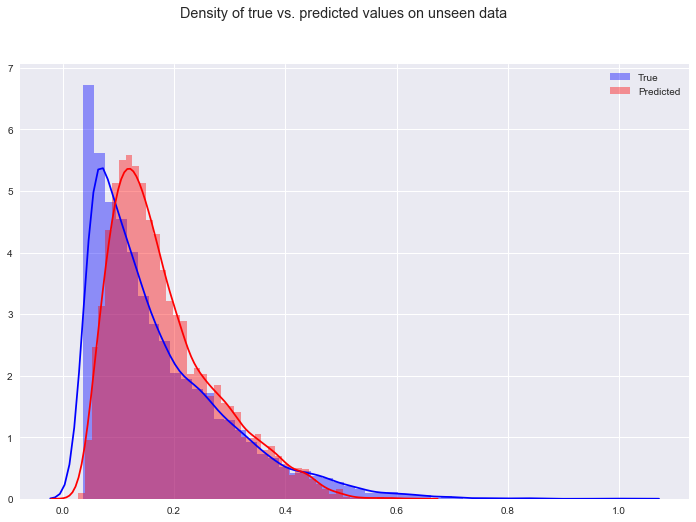

In [139]:
# Density plot of the test response variable and the predicted values
plt.figure(figsize=(12, 8))
sns.distplot(test_Y, norm_hist=True, color = 'blue', label = 'True')
sns.distplot(test_pred, norm_hist=True, color = 'red', label = 'Predicted')
sns.plt.suptitle('Density of true vs. predicted values on unseen data')
sns.plt.legend()
sns.plt.show()

Now let's see what happensif we build the model by first identifing any hidden states using a Hidden Markov Model and then train a GP model for each hidden state.  Prediction will be made by first identifing the most likely hidden state sequence using the Viterbi algorithm and then predicting with the GP model trained for that state. 

A dimensionality reduction can help us visualize the $X$ data since it has 12 features.  We use a PCA and plot the first 3 components of train_X. 

In [60]:
# PCA
sklearn_pca = sklearnPCA()
train_pca = sklearn_pca.fit_transform(train_X)

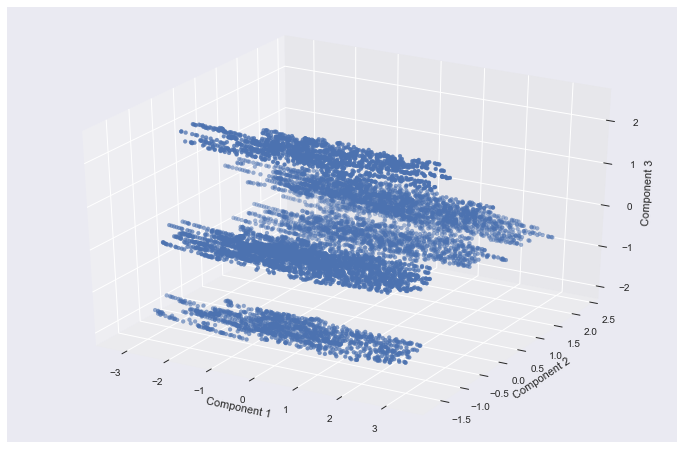

In [201]:
# plot the first 3 components 
plot_3d(train_pca)

In [202]:
# HMM model, we pick the number of components based on the PCA visualizations and the max log-liklihood.  
# The right number of hidden states looks to be 7
hmm = GaussianHMM(n_components=7, covariance_type="diag",min_covar=0.00001, tol = 0.01, n_iter=1000).fit(train_X)

# Predict the optimal sequence of internal hidden state for the training data
train_hidden_states = hmm.predict(train_X)
cols = ['r', 'b', 'g', 'y', 'k', 'c', 'm']
colors = [cols[x] for x in train_hidden_states]


3D plot of the first 3 PCA components colored by hidden state that produced the data point:


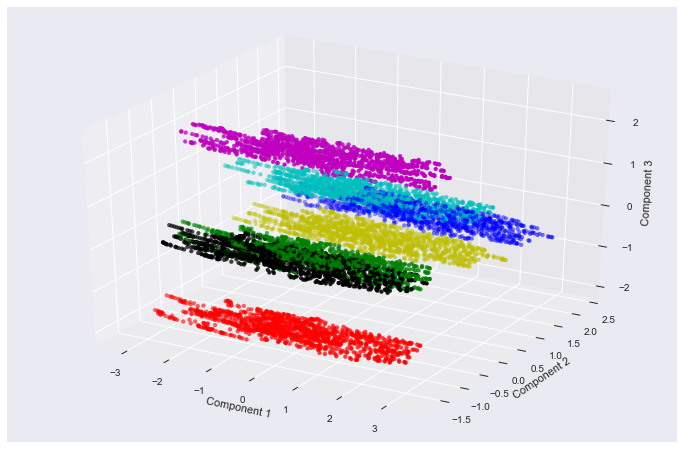

Plot of train_Y, the response variable, colored by the hidden state


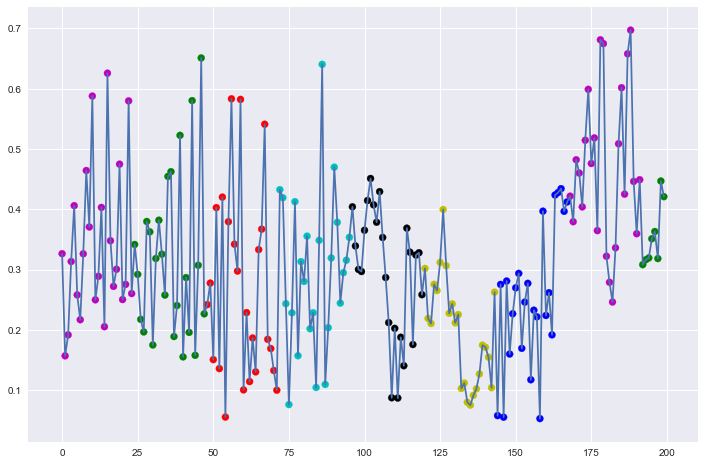

In [203]:
# 3D plot of the training data colored with the predicted hidden state for each data point.
print '3D plot of the first 3 PCA components colored by hidden state that produced the data point:'
plot_3d(train_pca, colors)


print 'Plot of train_Y, the response variable, colored by the hidden state'
# plot the train_X data with the hidden states color coded
plt.figure(figsize=(12, 8))
plt.plot(train_Y[0:200])
plt.scatter(np.arange(200), train_Y[0:200], c=colors)
plt.show()

In [317]:
def r2_rmse(model, state):
    print ' GP for Hidden state ', state
    print 'R-squared: ', model.score(train_X[np.where(train_hidden_states == state-1)], train_Y[np.where(train_hidden_states == state-1)])
    print 'RMSE: ', rmse(model.predict(train_X[np.where(train_hidden_states == state-1)]), train_Y[np.where(train_hidden_states == state-1)])

For each hidden state train a GP model using only examples from that hidden state. 

In [251]:
gp_hmm0 = gaussian_process.GaussianProcessRegressor(kernel=kernel, normalize_y = True, n_restarts_optimizer = 5).fit(
    train_X[np.where(train_hidden_states == 0)], train_Y[np.where(train_hidden_states == 0)])
gp_hmm1 = gaussian_process.GaussianProcessRegressor(kernel=kernel, normalize_y = True, n_restarts_optimizer = 5).fit(
    train_X[np.where(train_hidden_states == 1)], train_Y[np.where(train_hidden_states == 1)])
gp_hmm2 = gaussian_process.GaussianProcessRegressor(kernel=kernel, normalize_y = True, n_restarts_optimizer = 5).fit(
    train_X[np.where(train_hidden_states == 2)], train_Y[np.where(train_hidden_states == 2)])
gp_hmm3 = gaussian_process.GaussianProcessRegressor(kernel=kernel, normalize_y = True, n_restarts_optimizer = 5).fit(
    train_X[np.where(train_hidden_states == 3)], train_Y[np.where(train_hidden_states == 3)])
gp_hmm4 = gaussian_process.GaussianProcessRegressor(kernel=kernel, normalize_y = True, n_restarts_optimizer = 5).fit(
    train_X[np.where(train_hidden_states == 4)], train_Y[np.where(train_hidden_states == 4)])
gp_hmm5 = gaussian_process.GaussianProcessRegressor(kernel=kernel, normalize_y = True, n_restarts_optimizer = 5).fit(
    train_X[np.where(train_hidden_states == 5)], train_Y[np.where(train_hidden_states == 5)])
gp_hmm6 = gaussian_process.GaussianProcessRegressor(kernel=kernel, normalize_y = True, n_restarts_optimizer = 5).fit(
    train_X[np.where(train_hidden_states == 6)], train_Y[np.where(train_hidden_states == 6)])

In [316]:
models = {1:gp_hmm0, 2:gp_hmm1, 3:gp_hmm2, 4:gp_hmm3, 5:gp_hmm4, 6:gp_hmm5, 7:gp_hmm6}

Look at $R^2$, RMSE, and density plots of true vs. predicted on train_X

 GP for Hidden state  1
R-squared:  0.890279901217
RMSE:  0.0472569232202
--------------------
 GP for Hidden state  2
R-squared:  0.847866628116
RMSE:  0.0493376956047
--------------------
 GP for Hidden state  3
R-squared:  0.839472688292
RMSE:  0.053904724116
--------------------
 GP for Hidden state  4
R-squared:  0.890795029182
RMSE:  0.0399792993306
--------------------
 GP for Hidden state  5
R-squared:  0.92264867194
RMSE:  0.0393774206348
--------------------
 GP for Hidden state  6
R-squared:  0.898362920755
RMSE:  0.0480911647888
--------------------
 GP for Hidden state  7
R-squared:  0.823827875912
RMSE:  0.0531967998919
--------------------


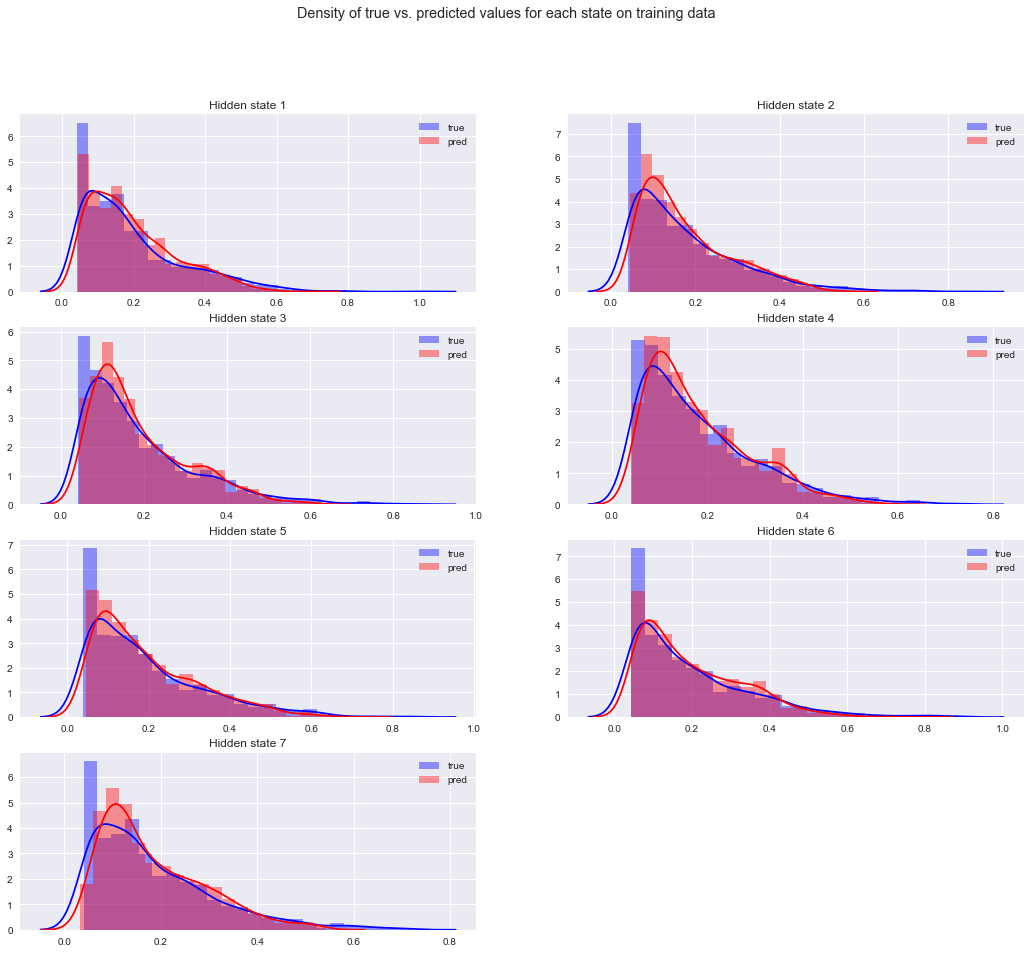

In [318]:
fig = plt.figure(figsize=(18, 15))
for i in np.arange(1, 8):
    r2_rmse(models[i], i)
    print '-'*20
    fig.add_subplot(4,2,i, title='Hidden state '+str(i))
    sns.distplot(train_Y[np.where(train_hidden_states == i-1)], norm_hist=True, color='blue',label = 'true')
    sns.distplot(models[i].predict(train_X[np.where(train_hidden_states == i-1)]), norm_hist=True,  color='red',label = 'pred')
    sns.plt.suptitle('Density of true vs. predicted values for each state on training data')
    sns.plt.legend()
    
plt.show()

Look at how the HMM_GP model performs on unseen test data

In [322]:
# predict the most likely state sequence for the unseen test data
test_hidden_states = hmm.predict(test_X)

In [368]:
# For each observation get the predicted hidden state and make a energy consumption prediction using the GP model for that state
test_pred_hmm_gp = []
test_std_hmm_gp = []
for idx in range(len(test_X)):
    state = test_hidden_states[idx]+1
    pred, std = models[state].predict(test_X[idx], return_std=True)
    test_pred_hmm_gp.append(pred)
    test_std_hmm_gp.append(std)
    
test_std_hmm_gp = np.asarray(test_std_hmm_gp).flatten()
test_pred_hmm_gp = np.asarray(test_pred_hmm_gp).flatten()

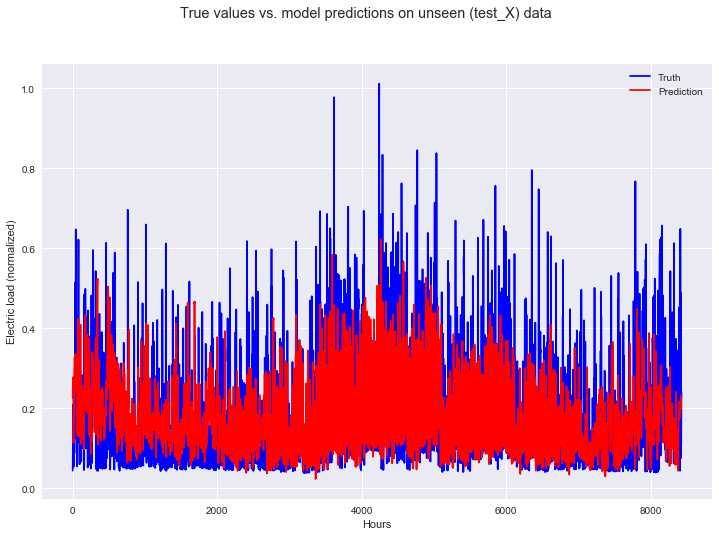

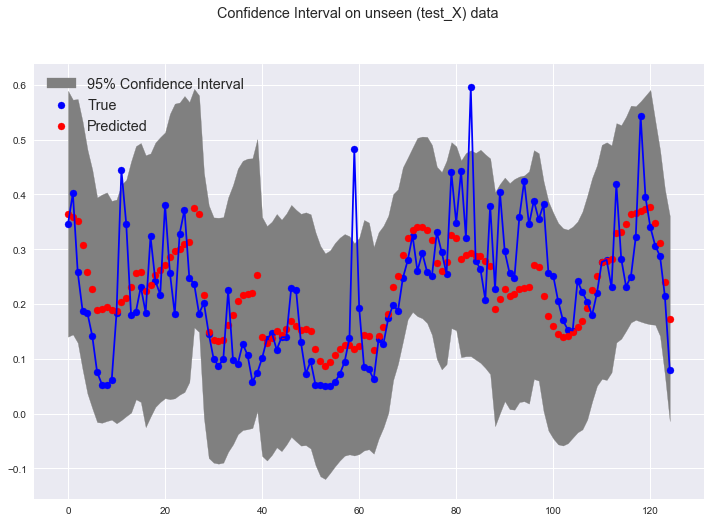

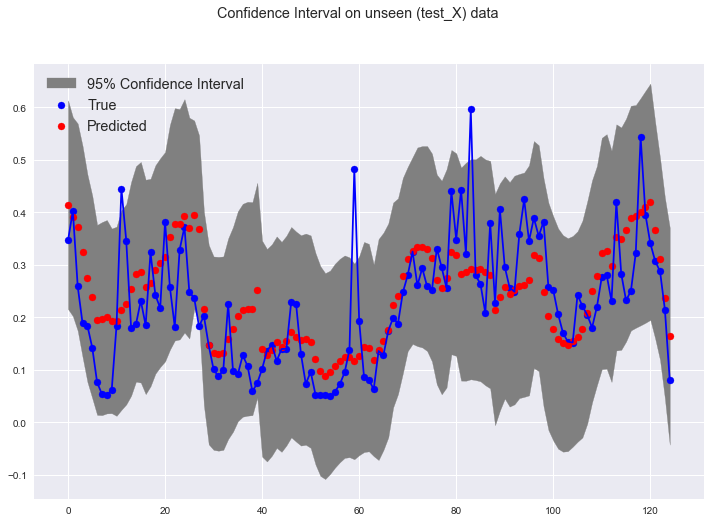

The percent of true values that fall within the confidence interval is  94.4681861349 %


In [344]:
plot_y([test_Y, test_pred_hmm_gp],  'True values vs. model predictions on unseen (test_X) data', 'Hours', 'Electric load (normalized)', ['Truth','Prediction'])

in_ci = plot_CI('Confidence Interval on unseen (test_X) data', test_Y, test_pred_hmm_gp, test_std_hmm_gp, 95, 200, 325)

print 'The percent of true values that fall within the confidence interval is ', 100*in_ci,'%'

In [383]:
def r_squared(models):
    scores = []
    for i in xrange(1, 8):
        scores.append(models[i].score(test_X[np.where(test_hidden_states == i-1)], test_Y[np.where(test_hidden_states == i-1)]))
    return np.mean(scores)

In [385]:
print 'R-squared for HMM_GP model: ', r_squared(models)
print 'RMSE for HMM_GP model: ', rmse(test_Y, test_pred_hmm_gp)

R-squared for HMM_GP model:  0.401514043025
RMSE for HMM_GP model:  0.0946281823983


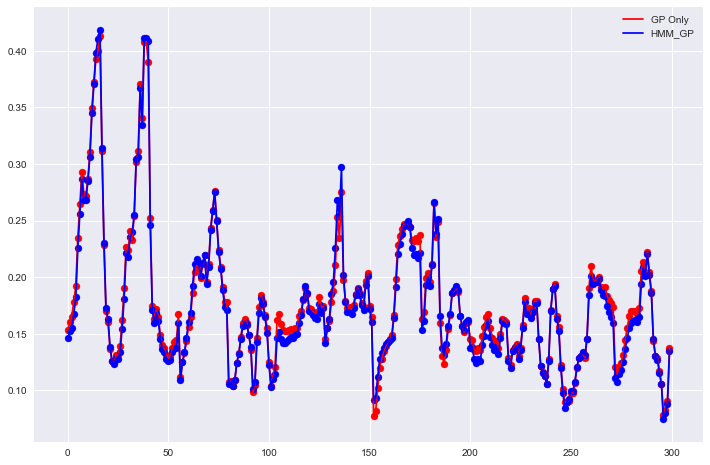

In [376]:
plt.figure(figsize=(12, 8))
plt.plot(test_pred_hmm_gp[1000:1300], color = 'red', label = 'GP Only')
plt.scatter(np.arange(300), test_pred_hmm_gp[1000:1300], color = 'red')
plt.plot(test_pred[1000:1300], color = 'blue', label = 'HMM_GP')
plt.scatter(np.arange(300), test_pred[1000:1300], color = 'blue')
plt.legend()
plt.show()